In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data_utils

torch.set_default_dtype(torch.float32)

## Load data

In [4]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

#### Subset the training set

In [5]:
# indices = torch.arange(100)
# trainset = data_utils.Subset(trainset, indices)

In [6]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

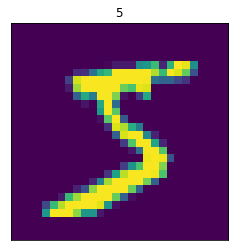

In [7]:
plt.imshow(trainset[0][0].reshape((28, 28)));
plt.title(trainset[0][1]);
plt.xticks([])
plt.yticks([]);

## Prepare a single network module

In [8]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out

In [9]:
def train_net(net, optimizer, epochs, verbose=False):
    for epoch in range(epochs): 
        running_loss = 0.0
        correct = 0
        total = 0
        net.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            if i % 100 == 0:    # print every 100 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f acc: %.3f%%' %
                          (epoch + 1, i, running_loss / 100, correct/total*100))
                running_loss = 0.0
                correct = 0
                total=0

        correct = 0
        test_loss = 0
        net.eval()
        for i, data in enumerate(testloader):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        print(f"Test acc: {correct/len(testset)*100}, loss: {test_loss/i:.3f}")
        
    return correct/len(testset)*100, test_loss/i

### Benchmark

#### Full network

In [27]:
net = SimpleNetwork(784)

In [28]:
criterion = torch.nn.CrossEntropyLoss()

In [29]:
%%time
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
train_net(net, optimizer, 5)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
final_loss = train_net(net, optimizer, 5)[0]

Test acc: 96.3, loss: 0.123
Test acc: 96.96000000000001, loss: 0.094
Test acc: 97.09, loss: 0.106
Test acc: 96.56, loss: 0.120
Test acc: 96.77, loss: 0.120
Test acc: 97.92, loss: 0.083
Test acc: 98.03, loss: 0.083
Test acc: 97.95, loss: 0.083
Test acc: 97.97, loss: 0.082
Test acc: 97.92, loss: 0.083
CPU times: user 17min 55s, sys: 1min 1s, total: 18min 56s
Wall time: 1min 41s


#### Masked input (for further benchmark)

In [20]:
input_size = 784
mask_size = 700

np.random.seed(42)
template = np.zeros(input_size)
mask_idx = np.random.choice(len(template), mask_size, False)
template[mask_idx] = 1
mask = torch.from_numpy(template).to(torch.bool)

In [21]:
mask_idx

array([598, 590, 209, 637, 174, 213, 429, 259, 593, 204, 576, 244, 235,
       218, 770, 155, 516,  67, 579, 109,  66, 522,  78, 473,  23, 211,
       706, 445, 644,  39, 332,  86, 137, 653, 656, 442, 525, 515, 334,
       630, 342, 780, 118, 652, 260, 779, 352, 432,  77, 691, 483, 682,
        49, 518, 168, 326, 377, 375, 568, 309, 629,  30, 361,  33,  31,
       627, 558, 405, 254, 412, 739, 486, 266, 331, 422, 231, 333, 357,
       620, 265,  54, 735, 514,  97, 506, 294, 234, 749, 311, 351, 120,
       436,  84,  10, 624, 464, 192, 530, 199,  29, 470, 323,  65, 350,
       659, 239,  81, 485, 291, 487, 264, 715, 535, 519,  76, 388, 523,
       570,  72, 693, 409, 208, 585,  63, 314, 672, 302, 750, 363, 393,
       752, 367, 705,   7, 533, 101, 428, 765, 745,   2, 398, 527, 764,
       196, 641, 729, 493, 448, 215, 425, 581, 417,  79, 148, 335, 247,
       559, 762, 133, 648,  55, 411, 597, 675, 545, 617, 720, 296, 362,
        60, 741, 360, 440, 662, 426, 383, 327, 584, 286,  90, 38

In [22]:
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

masked_net = MaskedNetwork(784, 700)
masked_net.mask = mask
optimizer = torch.optim.Adam(masked_net.parameters(), lr=3e-4)
train_net(masked_net, optimizer, 3)

Test acc: 89.24, loss: 0.401
Test acc: 90.67, loss: 0.332
Test acc: 91.27, loss: 0.308
Test acc: 91.24, loss: 0.299
Test acc: 91.46, loss: 0.290


KeyboardInterrupt: 

## Create simple network with insertable weights

In [30]:
flat_parameters = []
for layer in net.parameters():
    flat_parameters.extend(torch.flatten(layer).detach().numpy())
    
flat_parameters = torch.from_numpy(np.array(flat_parameters))

In [16]:
import torch.nn.functional as F

class InsertableNet(torch.nn.Module):
    def __init__(self, weights, shape=[(784, 10), (10, 10)]):
        super().__init__()
        self.layers = []
        self._offset = 0
        
        for layer in shape:
            _w_size = layer[0]*layer[1]
            _b_size = layer[1]
            
            _l = (weights[self._offset:self._offset+_w_size].reshape((layer[1], layer[0])),
                  weights[self._offset+_w_size:self._offset+_w_size+_b_size])
            self._offset += _w_size+_b_size

            self.layers.append(_l)
    
    def forward(self, data):
        out = data
        for layer in self.layers[:-1]:
            out = F.linear(out, layer[0], layer[1])
            out = F.relu(out)

        return F.linear(out, self.layers[-1][0], self.layers[-1][1])

In [17]:
insert_net = InsertableNet(flat_parameters, shape=[(784, 100), (100, 10)])

NameError: name 'flat_parameters' is not defined

In [36]:
correct = 0
for data in testloader:
    images, labels = data
    outputs = insert_net(images)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
print(f"Test acc: {correct/len(testset)*100}")
assert correct/len(testset)*100 == final_loss, correct/len(testset)*100

Test acc: 97.92


## Create hypernet structure

In [241]:
def partial_sum(data, mask, indices, splits):
    reshape = data.shape[-1]//splits
    
    if len(data.shape)==2:
        data = data[:, indices]
    else:
        data = data[indices]
    data_reordered = data.reshape(-1, splits, reshape)
    data_masked = data_reordered*F.softmax(mask.reshape(-1, reshape), dim=1)
    return data_masked.sum(dim=2)

In [242]:
data = torch.tensor([[0, 1, 2, 3, 4, 5]])
mask = torch.tensor([[0.1, 0.3, 0.4, 0.2, 0.1, 0.2]])
indices = torch.tensor([[1, 3, 2, 5, 0, 4]])
partial_sum(data, mask, indices, 3)

tensor([[2.0997, 3.3505, 2.0999]])

In [217]:
import enum 

class TrainingModes(enum.Enum):
    SLOW_STEP = "slow-step"
    CARTHESIAN = "carth"
    
class Hypernetwork(torch.nn.Module):
    def __init__(
        self,
        architecture=torch.nn.Sequential(torch.nn.Linear(784, 128), 
                        torch.nn.ReLU(),
                        torch.nn.Linear(128, 64),
                        torch.nn.ReLU(),
                        torch.nn.Linear(64, 64)
                       ),
        target_architecture=[(20, 10), (10, 10)],
        test_nodes=100,
        mode=TrainingModes.SLOW_STEP,
        device="cuda:0",
        trainable_masks=False,
        coeff=0.5
    ):
        """ Initialize a hypernetwork.
        Args:
            target_inp_size - size of input
            out_size - size of output
            layers - list of hidden layer sizes
            test_nodes - number of test nodes
            device - device to use
        """
        super().__init__()
        self.target_outsize = target_architecture[-1][-1]
        self.mask_size = target_architecture[0][0]
        self.target_architecture = target_architecture
        self.device = device
        self.mode = mode
        self.trainable_masks = trainable_masks

        self.out_size = self.calculate_outdim(target_architecture)

        self.model = architecture.to('cpu')
        gen = self.model.parameters()
        self.input_size = next(gen).size()[1]
        out_dim = self.model(torch.rand(1, self.input_size)).shape
        output_layer = torch.nn.Linear(out_dim[1], self.out_size)
        self.model.add_module("output_layer", output_layer)
        self.model = self.model
        
        self.template = np.zeros(self.input_size)
        self.test_nodes = test_nodes
        
        if self.trainable_masks:
            mask, self.indices = self._create_mask(test_nodes)
            self.register_parameter(name="test_mask",
                                    param=torch.nn.Parameter(mask*coeff, requires_grad=True))
        else:
            self.test_mask, self.indices = self._create_mask(test_nodes)

        self._retrained = True
        self._test_nets = None
        self.to(device)
        
    def calculate_outdim(self, architecture):
        weights = 0
        for layer in architecture:
            weights += layer[0]*layer[1]+layer[1]
        return weights

    def to(self, device):
        super().to(device)
        self.device = device
        if not self.trainable_masks:
            self.test_mask = self.test_mask.to(device)
        self.model = self.model.to(device)
        return self

    def _slow_step_training(self, data, mask, indices):
        weights = self.craft_network(mask[:1])
        mask = self._cast_masks(mask)[0]
        index = indices[0]
        
        nn = InsertableNet(
            weights[0],
            self.target_architecture,
        )
        
        masked_data = partial_sum(data, mask, index, self.mask_size)
        res = nn(masked_data)
        return res

    def _external_mask_training(self, data, mask, indices):
        recalculate = [True] * len(mask)
        for i in range(1, len(mask)):
            if torch.equal(mask[i - 1], mask[i]):
                recalculate[i] = False
                
        weights = self.craft_network(mask)

        res = torch.zeros((len(data), self.target_outsize)).to(self.device)
        for i in range(len(data)):
            if recalculate[i]:
                nn = InsertableNet(
                    weights[i],
                    self.target_architecture,
                )
            masked_data = partial_sum(data[i], mask[i], self.indices[i], self.mask_size)
            res[i] = nn(masked_data)
        return res

    def forward(self, data, mask=None, indices=None):
        """Get a hypernet prediction.
        During training we use a single target network per sample.
        During eval, we create a network for each test mask and average their results

        Args:
            data - prediction input
            mask - either None or a torch.tensor((data.shape[0], data.shape[1])).
        """
        if self.training:
            self._retrained = True
            if self.mode == TrainingModes.SLOW_STEP or self.mode == TrainingModes.CARTHESIAN:
                return self._slow_step_training(data, mask, indices)

            if mask is None and not self.trainable_masks:
                mask, indices = self._create_mask(len(data))

            return self._external_mask_training(data, mask, indices)
        else:
            return self._ensemble_inference(data, mask, indices)

    def _ensemble_inference(self, data, mask):
        if mask is None:
            mask = self.test_mask
            nets = self._get_test_nets()
        else:
            nets = self.__craft_nets(mask)

        mask = self._cast_masks(mask)

        res = torch.zeros((len(data), self.target_outsize)).to(self.device)
        for i in range(len(mask)):
            nn = nets[i]
            masked_data = data[:, mask[i]]
            res += nn(masked_data)
        res /= len(mask)
        return res

    def _get_test_nets(self):
        if self._retrained:
            nets = self.__craft_nets(self.test_mask)
            self._test_nets = nets
            self._retrained = False
        return self._test_nets

    def __craft_nets(self, mask):
        nets = []
        weights = self.craft_network(mask.to(torch.float32))
        for i in range(len(mask)):
            nn = InsertableNet(
                weights[i],
                self.target_architecture,
            )
            nets.append(nn)
        return nets

    @staticmethod
    def random_choice_noreplace2(l, n_sample, num_draw):
        '''
        l: 1-D array or list
        n_sample: sample size for each draw
        num_draw: number of draws

        Intuition: Randomly generate numbers, get the index of the smallest n_sample number for each row.
        '''
        l = np.array(l)
        return l[np.argpartition(np.random.rand(num_draw,len(l)), n_sample-1,axis=-1)[:,:n_sample]]
    
    def _create_mask(self, count):
        masks = torch.rand(count, self.input_size)
        indices = torch.argsort(torch.rand(*masks.shape), dim=-1)
        return masks, indices

    def _ind_to_mask(self, indices):
        tmp = np.array([self.template.copy() for _ in range(len(indices))])
        for i, ind in enumerate(indices):
            tmp[i, ind] = 1
        mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)
        return mask

    def craft_network(self, mask):
        out = self.model(mask)
        return out
    
    def _cast_masks(self, masks):
        if self.trainable_masks:
            ind = torch.topk(masks, self.mask_size, 1)[1].cpu().detach().numpy()
            masks = self._ind_to_mask(ind)
        
        return masks.to(torch.bool)

In [218]:
hypernet.indices.shape

torch.Size([100, 784])

In [219]:
from torchsummary import summary

In [228]:
# hypernet = Hypernetwork(mask_size=700, mode="regular").to("cpu")
hypernet = Hypernetwork(
    architecture=torch.nn.Sequential(torch.nn.Linear(784, 64), 
                        torch.nn.ReLU(),
                        torch.nn.Linear(64, 256),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(),
                        torch.nn.Linear(256, 128),
                        torch.nn.ReLU()
                       ),
    mode=None,
    target_architecture=[(784//8, 20), (20, 10)]).to("cpu")

In [229]:
list(hypernet.parameters())[0]

Parameter containing:
tensor([[-0.0103,  0.0248,  0.0256,  ...,  0.0216,  0.0340, -0.0142],
        [-0.0270,  0.0268,  0.0045,  ..., -0.0194,  0.0289, -0.0133],
        [-0.0293, -0.0238,  0.0297,  ...,  0.0040, -0.0213,  0.0059],
        ...,
        [ 0.0139, -0.0062,  0.0119,  ...,  0.0297,  0.0119, -0.0293],
        [-0.0182, -0.0197, -0.0031,  ...,  0.0198,  0.0351, -0.0142],
        [-0.0333, -0.0222,  0.0192,  ...,  0.0190, -0.0038, -0.0200]],
       requires_grad=True)

In [230]:
summary(hypernet, (784, ), batch_size=5, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [5, 64]          50,240
              ReLU-2                    [5, 64]               0
            Linear-3                   [5, 256]          16,640
              ReLU-4                   [5, 256]               0
           Dropout-5                   [5, 256]               0
            Linear-6                   [5, 128]          32,896
              ReLU-7                   [5, 128]               0
            Linear-8                  [5, 2190]         282,510
Total params: 382,286
Trainable params: 382,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 1.46
Estimated Total Size (MB): 1.60
----------------------------------------------------------------


In [233]:
hypernet.test_mask

tensor([[0.6286, 0.7059, 0.1138,  ..., 0.2786, 0.3919, 0.9425],
        [0.5904, 0.2115, 0.7692,  ..., 0.9993, 0.1279, 0.9381],
        [0.3648, 0.6093, 0.9203,  ..., 0.9763, 0.6816, 0.6718],
        ...,
        [0.7971, 0.0202, 0.2039,  ..., 0.3911, 0.2439, 0.5920],
        [0.7183, 0.7228, 0.0208,  ..., 0.7715, 0.9373, 0.2949],
        [0.2341, 0.6303, 0.3179,  ..., 0.5540, 0.3475, 0.8039]])

In [232]:
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
train_net(hypernet, optimizer, 1, verbose=True);

[1,     0] loss: 0.023 acc: 6.250%
[1,   100] loss: 2.154 acc: 20.578%
[1,   200] loss: 2.102 acc: 22.125%
[1,   300] loss: 2.058 acc: 24.266%
[1,   400] loss: 2.050 acc: 24.703%
[1,   500] loss: 2.044 acc: 24.406%
[1,   600] loss: 2.031 acc: 26.344%
[1,   700] loss: 2.028 acc: 26.016%
[1,   800] loss: 2.002 acc: 26.234%
[1,   900] loss: 1.989 acc: 28.031%


TypeError: _ensemble_inference() takes 3 positional arguments but 4 were given

In [20]:
list(hypernet.parameters())[0]

Parameter containing:
tensor([[ 0.0214,  0.0204, -0.0131,  ...,  0.0084,  0.0010,  0.0335],
        [ 0.0088,  0.0156, -0.0109,  ..., -0.0034,  0.0122, -0.0194],
        [ 0.0281, -0.0366, -0.0069,  ...,  0.0239,  0.0160, -0.0212],
        ...,
        [-0.0139,  0.0052,  0.0176,  ...,  0.0258,  0.0222,  0.0100],
        [-0.0061, -0.0216, -0.0269,  ..., -0.0178,  0.0164,  0.0130],
        [ 0.0086, -0.0051, -0.0328,  ..., -0.0327, -0.0253,  0.0268]],
       requires_grad=True)

## Conclusion
The network is able to train, so everything is working as expected. Now, we can focus on the raw score optimization.